In [4]:
import pandas as pd
import json
import http.client
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np

In [17]:
def create_dataframe(yearfrom, yearto, API_key):
    """
    Create a DataFrame from the standings data for a specified range of years.

    Parameters:
        yearfrom (int): Starting year.
        yearto (int): Ending year.
        API_key (str): API key for accessing the football API.

    Returns:
        df_list (list): List of DataFrames, each containing standings data for one season.
    """
    df_list = []
    for year in range(yearfrom, yearto):
        try:
            conn = http.client.HTTPSConnection("v3.football.api-sports.io")

            headers = {
                'x-rapidapi-host': "v3.football.api-sports.io",
                'x-rapidapi-key': f"{API_key}"
                }

            conn.request("GET", f"/standings?league=39&season={year}", headers=headers)

            res = conn.getresponse()
            data = res.read()
            # Decode bytes to string
            json_string = data.decode('utf-8')

            # Parse JSON string
            json_data = json.loads(json_string)

            # Check if response contains data
            if json_data and 'response' in json_data and json_data['response']:
                standings_data = json_data['response'][0]['league']['standings'][0]

                # Convert to pandas DataFrame
                df = pd.DataFrame(standings_data)

                # Append DataFrame to the list
                df_list.append(df)
            else:
                print(f"No data available for {year}.")
        except Exception as e:
            print(f"Error occurred for {year}: {e}")

    return df_list


In [24]:
df = create_dataframe(2015,2024, API_key=)

In [6]:
def split_columns(lst):
    """
    Split columns containing nested JSON objects into separate DataFrames and combine them with the original DataFrame.

    Parameters:
        lst (list): A list of pandas DataFrames where each DataFrame contains columns with nested JSON objects.

    Returns:
        list: A list of pandas DataFrames with split columns combined with the original DataFrames.
    """
    # List to store DataFrames after splitting columns
    return_lst = []

    # Iterate over each DataFrame in the input list
    for df in lst:
        # Split the 'team', 'all', 'home', and 'away' columns into separate DataFrames
        df_team = pd.json_normalize(df['team'])
        df_all = pd.json_normalize(df['all'])
        df_home = pd.json_normalize(df['home'])
        df_away = pd.json_normalize(df['away'])

        # Add prefix to columns based on their original column name
        df_all = df_all.add_prefix('all_')
        df_home = df_home.add_prefix('home_')
        df_away = df_away.add_prefix('away_')

        # Combine the split columns with the original DataFrame
        df = pd.concat([df.drop(['team', 'all', 'home', 'away'], axis=1), df_team, df_all, df_home, df_away], axis=1)

        # Append the DataFrame to the return list
        return_lst.append(df)

    # Return the list of DataFrames after splitting columns
    return return_lst



In [25]:
df_list = split_columns(df)

In [7]:
def drop_columns(lst):
    """
    Drop specified columns from each DataFrame in a list of DataFrames.

    Parameters:
        lst (list): A list of pandas DataFrames.

    Returns:
        list: A list of pandas DataFrames with specified columns dropped.
    """
    # Iterate over each DataFrame in the input list
    for df in lst:
        # Drop specified columns
        df.drop(columns=["id", "update", "status"], inplace=True)

    # Return the modified list of DataFrames
    return lst

In [26]:
df_list = split_columns(df_list)

KeyError: 'team'

In [27]:
df_list[0]

,rank,points,goalsDiff,group,form,status,description,update,id,name,...,home_draw,home_lose,home_goals.for,home_goals.against,away_played,away_win,away_draw,away_lose,away_goals.for,away_goals.against
0,1,81,32,Premier League,DWDWD,None,UEFA Champions League,2018-02-15T00:00:00+00:00,46,Leicester,...,6,1,35,18,19,11,6,2,33,18
1,2,71,29,Premier League,WDWDW,None,UEFA Champions League,2018-02-15T00:00:00+00:00,42,Arsenal,...,4,3,31,11,19,8,7,4,34,25
2,3,70,34,Premier League,LLDDW,None,UEFA Champions League,2018-02-15T00:00:00+00:00,47,Tottenham,...,6,3,35,15,19,9,7,3,34,20
3,4,66,30,Premier League,DDLWD,None,UEFA Champions League Qualifiers,2018-02-15T00:00:00+00:00,50,Manchester City,...,2,5,47,21,19,7,7,5,24,20
4,5,66,14,Premier League,WLWDW,None,UEFA Europa League,2018-02-15T00:00:00+00:00,33,Manchester United,...,5,2,27,9,19,7,4,8,22,26
5,6,63,18,Premier League,WWWWD,None,None,2018-02-15T00:00:00+00:00,41,Southampton,...,3,5,39,22,19,7,6,6,20,19
6,7,62,14,Premier League,LWLWW,None,None,2018-02-15T00:00:00+00:00,48,West Ham,...,7,3,34,26,19,7,7,5,31,25
7,8,60,13,Premier League,DDWLD,None,None,2018-02-15T00:00:00+00:00,40,Liverpool,...,8,3,33,22,19,8,4,7,30,28
8,9,51,-14,Premier League,WLDLL,None,None,2018-02-15T00:00:00+00:00,75,Stoke City,...,4,7,22,24,19,6,5,8,19,31
9,10,50,6,Premier League,DDLDW,None,None,2018-02-15T00:00:00+00:00,49,Chelsea,...,9,5,32,30,19,7,5,7,27,23


In [28]:
drop_columns(df_list)

[    rank  points  goalsDiff           group   form  \
 0      1      81         32  Premier League  DWDWD   
 1      2      71         29  Premier League  WDWDW   
 2      3      70         34  Premier League  LLDDW   
 3      4      66         30  Premier League  DDLWD   
 4      5      66         14  Premier League  WLWDW   
 5      6      63         18  Premier League  WWWWD   
 6      7      62         14  Premier League  LWLWW   
 7      8      60         13  Premier League  DDWLD   
 8      9      51        -14  Premier League  WLDLL   
 9     10      50          6  Premier League  DDLDW   
 10    11      47          4  Premier League  WLLWL   
 11    12      47        -10  Premier League  DWWLL   
 12    13      45        -10  Premier League  DLLWL   
 13    14      43        -14  Premier League  DDLDL   
 14    15      42        -12  Premier League  LWLLD   
 15    16      42        -22  Premier League  LDLLL   
 16    17      39        -14  Premier League  DWWDD   
 17    18 

In [236]:
df_list[0].columns

Index(['rank', 'points', 'goalsDiff', 'group', 'form', 'description', 'name',
       'logo', 'all_played', 'all_win', 'all_draw', 'all_lose',
       'all_goals.for', 'all_goals.against', 'home_played', 'home_win',
       'home_draw', 'home_lose', 'home_goals.for', 'home_goals.against',
       'away_played', 'away_win', 'away_draw', 'away_lose', 'away_goals.for',
       'away_goals.against'],
      dtype='object')

In [29]:
def column_names(df_list):
   df_list_cleaned = []
   for df in df_list:
      df=df[['rank','name', 'points', 'goalsDiff', 'group', 'form', 'description', 
         'logo', 'all_played', 'all_win', 'all_draw', 'all_lose',
         'all_goals.for', 'all_goals.against', 'home_played', 'home_win',
         'home_draw', 'home_lose', 'home_goals.for', 'home_goals.against',
         'away_played', 'away_win', 'away_draw', 'away_lose', 'away_goals.for',
         'away_goals.against']]
      df_list_cleaned.append(df)
   return df_list_cleaned

In [30]:
df_list_cleaned = column_names(df_list)

In [31]:
def make_big_df(df_list, fromyear, toyear):
    """
    Combine multiple DataFrames into a single DataFrame with an added 'season' column.

    Parameters:
        df_list (list): A list of pandas DataFrames.
        fromyear (int): Starting year for the seasons.
        toyear (int): Ending year (exclusive) for the seasons.

    Returns:
        pandas.DataFrame: A single pandas DataFrame containing data from all input DataFrames with an added 'season' column.
    """
    # Define seasons range
    seasons = range(fromyear, toyear)

    # Add 'season' column to each DataFrame
    for season, df in zip(seasons, df_list):
        df['season'] = season

    # Concatenate all DataFrames into a single big DataFrame
    big_df = pd.concat(df_list, ignore_index=True)

    # Return the combined DataFrame
    return big_df
    


In [32]:
pl = make_big_df(df_list,2015,2024)

In [33]:

def plot_top_teams_position(pl, num_teams=6, figsize=(10, 6), save_path=None):
    """
    Plot the league position per season for the top N teams.

    Parameters:
        pl (DataFrame): DataFrame containing the league position data.
        num_teams (int): Number of top teams to include in the plot.
        figsize (tuple): Figure size (width, height) in inches.
        save_path (str): Path to save the plot (including filename and extension).

    Returns:
        None
    """
    # Pivot the data to have one line per team
    rank_per_season_pivot = pl.pivot_table(index='season', columns='name', values='rank', aggfunc='mean')

    # Calculate the mean rank for each team across all seasons
    mean_rank_per_team = rank_per_season_pivot.mean().sort_values()

    # Select the top N teams
    top_teams = mean_rank_per_team.head(num_teams).index

    # Filter the data to include only the top N teams
    rank_per_season_pivot_filtered = rank_per_season_pivot[top_teams]

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)

    # Create the line chart
    rank_per_season_pivot_filtered.plot(kind='line', marker='o', ax=ax, markersize=6)

    # Customize the plot
    ax.set_title(f'League position per season for top {num_teams} teams', fontsize=20)
    ax.set_xlabel('Season')
    ax.set_ylabel('Rank')

    # Filter out NaN and Inf values from the data
    cleaned_values = rank_per_season_pivot_filtered.values[~np.isnan(rank_per_season_pivot_filtered.values) & ~np.isinf(rank_per_season_pivot_filtered.values)]

    # Set y-axis limits and ticks
    extra_space = 1
    ax.set_ylim(cleaned_values.min() - extra_space, cleaned_values.max())
    ax.set_yticks(np.unique(cleaned_values))
    ax.invert_yaxis()

    plt.xticks(rotation=12, fontsize=12)
    plt.yticks(fontsize=12)

    # Move legend outside of the graph
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Teams')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, transparent=True, bbox_inches='tight')

    plt.show()


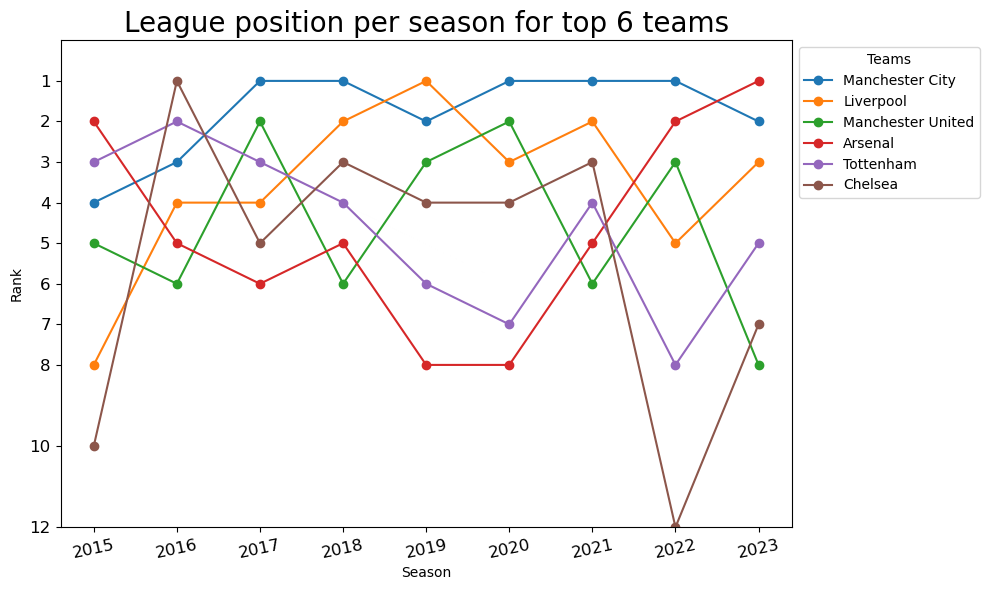

In [48]:
plot_top_teams_position(pl,save_path='top_6_positions.png')

In [10]:

def plot_top_teams_points(pl, num_teams=6, figsize=(10, 6), save_path=None):
    """
    Plot the points per season for the top N teams.

    Parameters:
        pl (DataFrame): DataFrame containing the points data.
        num_teams (int): Number of top teams to include in the plot.
        figsize (tuple): Figure size (width, height) in inches.
        save_path (str): Path to save the plot (including filename and extension).

    Returns:
        None
    """
    # Pivot the data to have one line per team
    points_per_season_pivot = pl.pivot_table(index='season', columns='name', values='points', aggfunc='mean')

    # Calculate the mean points for each team across all seasons
    mean_points_per_team = points_per_season_pivot.mean().sort_values(ascending=False)

    # Select the top N teams
    top_teams = mean_points_per_team.head(num_teams).index

    # Filter the data to include only the top N teams
    points_per_season_pivot_filtered = points_per_season_pivot[top_teams]

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)

    # Create the bar chart with custom colors
    colors = ['#6CABDD', '#c8102E', '#9C824A', '#132257', '#FBE122', '#034694']
    team_colors = {team: color for team, color in zip(top_teams, colors)}
    points_per_season_pivot_filtered.plot(kind='bar', ax=ax, color=[team_colors.get(team, 'black') for team in points_per_season_pivot_filtered.columns])

    # Customize the plot
    ax.set_title(f'Points per season for top {num_teams} teams', fontsize=20)
    ax.set_xlabel('Season')
    ax.set_ylabel('Points')

    plt.xticks(rotation=12, fontsize=12)
    plt.yticks(fontsize=12)

    # Move legend outside of the graph
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Teams')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, transparent=True, bbox_inches='tight')

    plt.show()


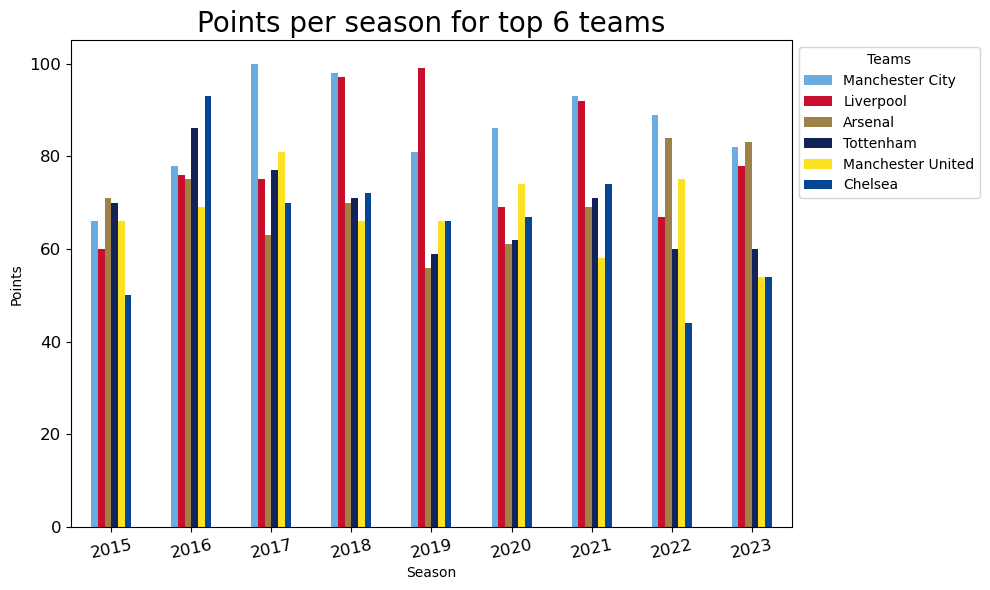

In [34]:
plot_top_teams_points(pl,save_path='top_6_points.png')

In [11]:
def plot_team_goal_difference(pl, team_name, figsize=(10, 6), save_path=None):
    """
    Plot the goal difference per season for a specific team.

    Parameters:
        pl (DataFrame): DataFrame containing the league position data.
        team_name (str): Name of the team to plot the goal difference for.
        figsize (tuple): Figure size (width, height) in inches.
        save_path (str): Path to save the plot (including filename and extension).

    Returns:
        None
    """
    # Filter the data for the specified team
    team_data = pl.loc[pl["name"] == team_name]

    # Group the data by season and calculate the mean goals for and against each season
    team_goals = team_data.groupby(["season"]).agg({'all_goals.for': 'mean', 'all_goals.against': 'mean', 'goalsDiff': 'mean'}).reset_index()

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_ylim(0, 120)

    # Create the line chart for goals scored
    team_goals.plot(x='season', y='all_goals.for', kind='line', marker='o', markersize=9, ax=ax, label='Goals For', color="#c8102E")

    # Plot goal difference
    team_goals.plot(x='season', y='goalsDiff', kind='line', marker='o', markersize=9, ax=ax, label='Goal Difference', color="#F6EB61")

    # Create another line chart for goals against
    team_goals.plot(x='season', y='all_goals.against', kind='line', marker='o', markersize=9, ax=ax, label='Goals Against', color="#00B2A9")

    # Customize the plot
    ax.set_title(f'Goal Difference per Season for {team_name}', fontsize=20)
    ax.set_xlabel('Season')
    ax.set_ylabel('Goals')
    plt.xticks(rotation=12, fontsize=12)  # Rotate x-axis labels for better readability
    plt.yticks(fontsize=12)

    # Move legend outside of the graph
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Metrics')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, transparent=True, bbox_inches='tight')

    plt.show()


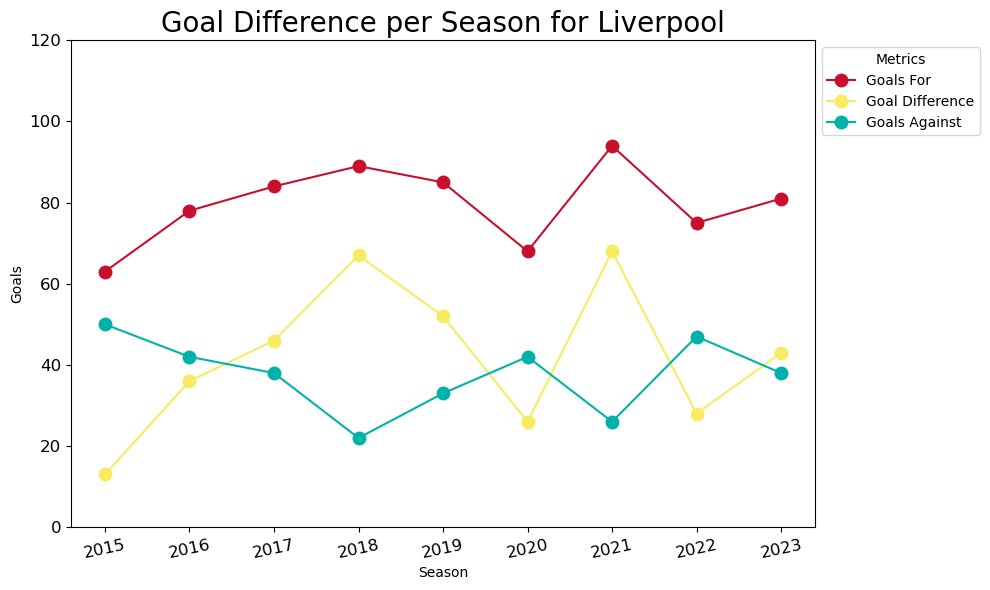

In [35]:
plot_team_goal_difference(pl, team_name="Liverpool", figsize=(10, 6), save_path="goal_difference_liverpool.png")


In [36]:
def plot_team_goal_difference_and_points(pl, team_name, figsize=(10, 6), save_path=None):
    """
    Plot the goal difference and points per season for a specific team.

    Parameters:
        pl (DataFrame): DataFrame containing the league position data.
        team_name (str): Name of the team to plot the goal difference and points for.
        figsize (tuple): Figure size (width, height) in inches.
        save_path (str): Path to save the plot (including filename and extension).

    Returns:
        None
    """
    # Filter the data for the specified team
    team_data = pl.loc[pl["name"] == team_name]

    # Group the data by season and calculate the mean metrics for each season
    team_metrics = team_data.groupby(["season"]).agg({'all_goals.for': 'mean', 'all_goals.against': 'mean', 'goalsDiff': 'mean', 'points': 'mean'}).reset_index()

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_ylim(0, 120)

    # Create the line chart for goals scored
    team_metrics.plot(x='season', y='all_goals.for', kind='line', marker='o', markersize=9, ax=ax, label='Goals For', color="#c8102E")

    # Plot goal difference
    team_metrics.plot(x='season', y='goalsDiff', kind='line', marker='o', markersize=9, ax=ax, label='Goal Difference', color="#F6EB61")

    # Create another line chart for goals against
    team_metrics.plot(x='season', y='all_goals.against', kind='line', marker='o', markersize=9, ax=ax, label='Goals Against', color="#00B2A9")

    # Create a line chart for points
    team_metrics.plot(x='season', y='points', kind='line', marker='o', markersize=9, ax=ax, label='Points', color="#73091a")

    # Customize the plot
    ax.set_title(f'Goal Difference and Points per Season for {team_name}', fontsize=20)
    ax.set_xlabel('Season')
    ax.set_ylabel('Metrics')
    plt.xticks(rotation=12, fontsize=12)  # Rotate x-axis labels for better readability
    plt.yticks(fontsize=12)

    # Move legend outside of the graph
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Metrics')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, transparent=True, bbox_inches='tight')

    plt.show()


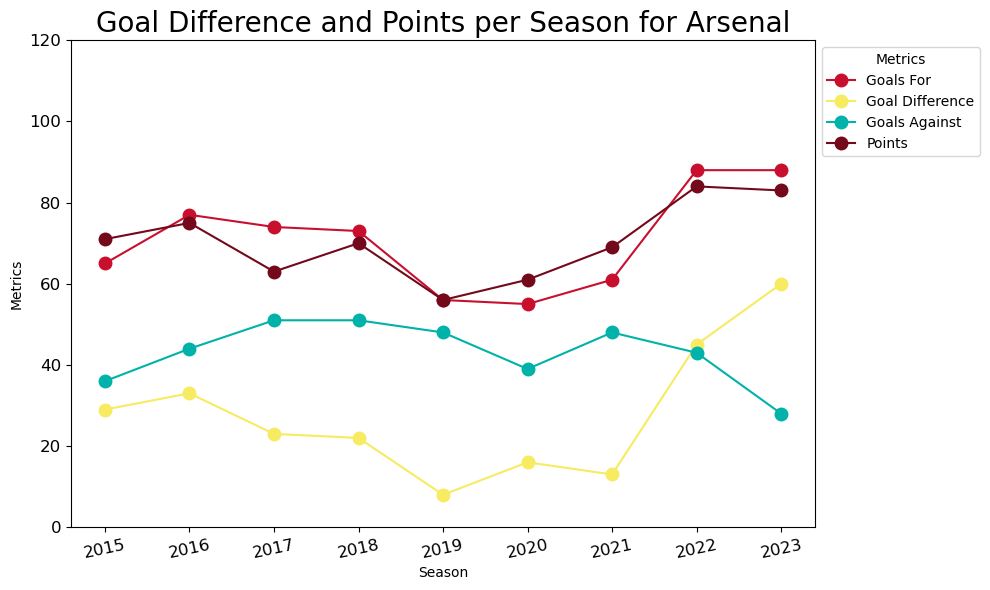

In [47]:
plot_team_goal_difference_and_points(pl,'Arsenal',save_path='arsenal_goals_points.png')

In [37]:
def plot_team_goals_home_away(pl, team_name, figsize=(10, 6), save_path=None):
    """
    Plot the total goals scored and conceded per season for a specific team.

    Parameters:
        pl (DataFrame): DataFrame containing the league position data.
        team_name (str): Name of the team to plot the goals for.
        figsize (tuple): Figure size (width, height) in inches.
        save_path (str): Path to save the plot (including filename and extension).

    Returns:
        None
    """
    # Filter the data for the specified team
    team_data = pl.loc[pl["name"] == team_name]

    # Group the data by season and calculate the total goals scored and conceded per season
    team_goals_home_away = team_data.groupby(["season"]).agg({'home_goals.for': 'sum', 'away_goals.for': 'sum', 'home_goals.against': 'sum', 'away_goals.against': 'sum'}).reset_index()

    # Create plot
    fig, ax = plt.subplots(figsize=figsize, facecolor='none')

    # Define custom colors for the bars
    colors = ['#c8102e', '#10c8aa', '#73091a', '#097362']

    # Create the bar chart with custom colors
    bars = team_goals_home_away.plot(kind='bar', x='season', ax=ax, color=colors)

    # Customize the plot
    ax.set_title(f'Goals Scored and Conceded per Season for {team_name}', fontsize=20)
    ax.set_xlabel('Season')
    ax.set_ylabel('Goals')
    plt.xticks(rotation=12, fontsize=12)
    plt.yticks(fontsize=12)

    # Move legend outside of the graph
    legend_labels = ['Home Goals Scored', 'Away Goals Scored', 'Home Goals Conceded', 'Away Goals Conceded']
    plt.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title='Goals')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, transparent=True, bbox_inches='tight')

    plt.show()


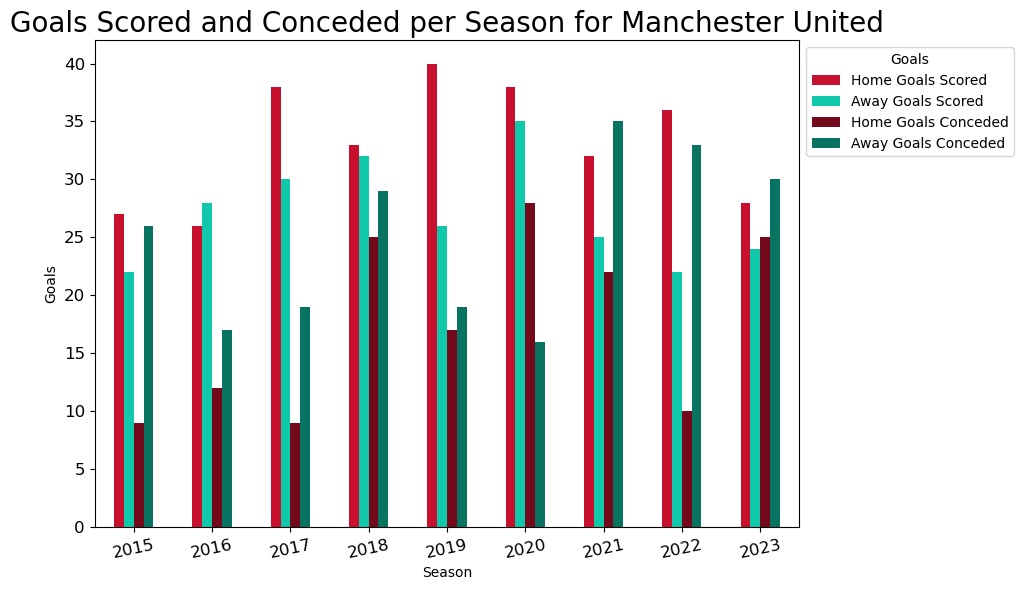

In [46]:
plot_team_goals_home_away(pl,'Manchester United', save_path='manu_goals_home_away.png')

In [38]:
def plot_team_win_rate(pl, team_name, figsize=(8, 6), save_path=None):
    """
    Plot the win rate for home and away games per season for a specific team.

    Parameters:
        pl (DataFrame): DataFrame containing the league position data.
        team_name (str): Name of the team to plot the win rate for.
        figsize (tuple): Figure size (width, height) in inches.
        save_path (str): Path to save the plot (including filename and extension).

    Returns:
        None
    """
    # Filter the data for the specified team
    team_data = pl.loc[pl["name"] == team_name]

    # Calculate the win rate for home and away games for each season
    home_win_rate_per_season = (team_data.groupby('season')['home_win'].mean() / team_data.groupby('season')['home_played'].mean()) * 100
    away_win_rate_per_season = (team_data.groupby('season')['away_win'].mean() / team_data.groupby('season')['away_played'].mean()) * 100

    # Plot the scatter plot
    fig, ax = plt.subplots(figsize=figsize, facecolor='none')

    # Set x and y axis limits to 0-100%
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

    # Iterate over each season and plot the data points with a unique color
    seasons = sorted(team_data['season'].unique())
    for i, season in enumerate(seasons):
        # Get the win rates for the current season
        home_win_rate = home_win_rate_per_season.loc[season]
        away_win_rate = away_win_rate_per_season.loc[season]
        
        # Define a unique color for each season
        color = plt.cm.tab10(i / len(seasons))  # Using a colormap to generate distinct colors
        
        # Scatter plot
        ax.scatter(home_win_rate, away_win_rate, label=season, color=color, s=125, edgecolor="black")

    # Customize the plot
    ax.set_title(f'{team_name} Home vs Away Win Rate per Season', fontsize=20)
    ax.set_xlabel('Home Win Rate (%)')
    ax.set_ylabel('Away Win Rate (%)')

    plt.xticks(range(10, 110, 10), fontsize=12)
    plt.yticks(range(10, 110, 10), fontsize=12)
    
    plt.grid(True, alpha=0.5)

    # Add legend
    ax.legend(title='Season')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, transparent=True, bbox_inches='tight')

    plt.show()


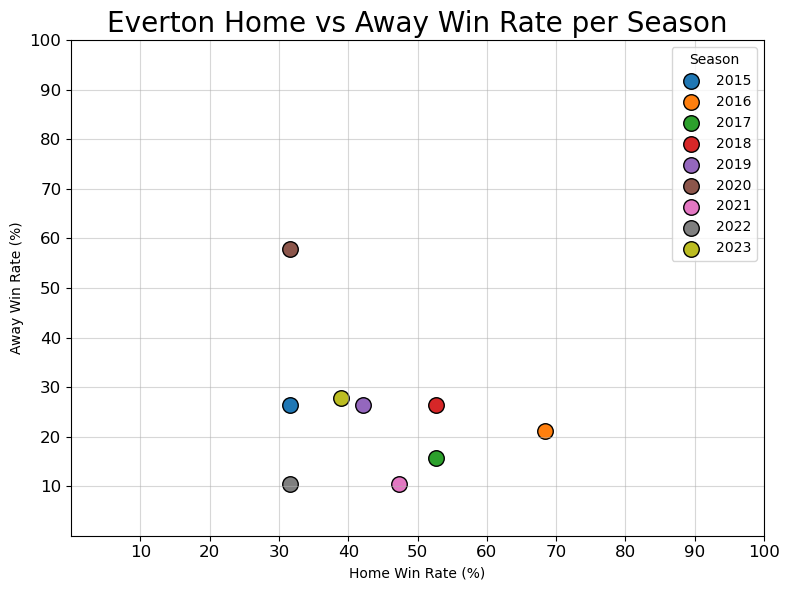

In [45]:
plot_team_win_rate(pl,"Everton", save_path='everton_winrate.png')

In [40]:
def plot_team_placement_vs_points(pl, team_name, figsize=(8, 6), save_path=None):
    """
    Plot the league placement vs points per season for a specific team.

    Parameters:
        pl (DataFrame): DataFrame containing the league position data.
        team_name (str): Name of the team to plot the data for.
        figsize (tuple): Figure size (width, height) in inches.
        save_path (str): Path to save the plot (including filename and extension).

    Returns:
        None
    """
    # Filter the data for the specified team
    team_data = pl.loc[pl["name"] == team_name]

    # Group the data by season and calculate the total points and rank for each season
    rank_per_season = team_data.groupby('season')['rank'].sum()
    points_per_season = team_data.groupby('season')['points'].sum()

    # Plot the scatter plot
    fig, ax = plt.subplots(figsize=figsize, facecolor='none')

    # Set x and y axis limits
    ax.set_xlim(20, 0)
    ax.set_ylim(0, 120)

    # Iterate over each season and plot the data points with a unique color
    seasons = sorted(team_data['season'].unique())
    for i, season in enumerate(seasons):
        # Get the points and rank for the current season
        points = points_per_season.loc[season]
        rank = rank_per_season.loc[season]
        
        # Define a unique color for each season
        color = plt.cm.tab10(i / len(seasons))  # Using a colormap to generate distinct colors
        
        # Scatter plot
        ax.scatter(rank, points, label=season, color=color, s=125, edgecolor="black")

    # Customize the plot
    ax.set_title(f'{team_name} League Placement vs Points per season', fontsize=20)
    ax.set_ylabel('Points')
    ax.set_xlabel('League Placement')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xticks(range(1, 21))
    plt.yticks(range(10, 120, 10))
    plt.grid(True, alpha=0.5)

    # Add legend
    ax.legend(title='Season')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, transparent=True, bbox_inches='tight')

    plt.show()


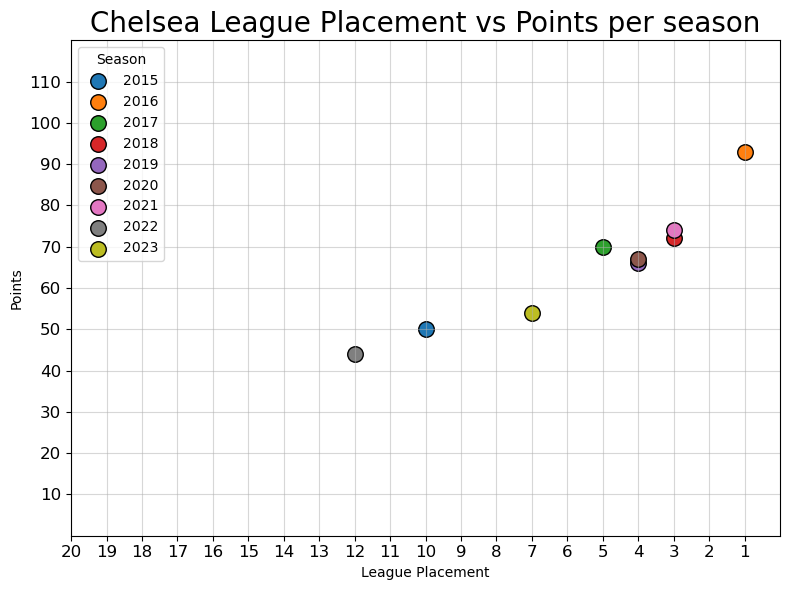

In [44]:
plot_team_placement_vs_points(pl,'Chelsea',save_path='chelsea_rank_points.png')

In [41]:
def plot_team_goals(pl, team_name, figsize=(10, 6), save_path=None):
    """
    Plot the goals scored and conceded per season for a specific team.

    Parameters:
        pl (DataFrame): DataFrame containing the league position data.
        team_name (str): Name of the team to plot the data for.
        figsize (tuple): Figure size (width, height) in inches.
        save_path (str): Path to save the plot (including filename and extension).

    Returns:
        None
    """
    # Filter the data for the specified team
    team_data = pl.loc[pl["name"] == team_name]

    # Group the data by season and calculate the total goals scored and conceded for each season
    goals_home_away = team_data.groupby(["season"]).agg({'home_goals.for': 'sum', 'home_goals.against': 'sum', 'away_goals.for': 'sum', 'away_goals.against': 'sum'}).reset_index()

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)

    # Create the bar chart with custom colors
    colors = ['#c8102e', '#73091a', '#10c8aa', '#097362']
    bars = goals_home_away.plot(kind='bar', x='season', ax=ax, color=colors)

    # Customize the plot
    ax.set_title('Goals Scored and Conceded per Season', fontsize=20)
    ax.set_xlabel('Season')
    ax.set_ylabel('Goals')
    plt.xticks(rotation=12, fontsize=12)  # Rotate x-axis labels for better readability
    plt.yticks(fontsize=12)

    # Move legend outside of the graph
    legend_labels = ['Home Goals Scored', 'Home Goals Conceded', 'Away Goals Scored', 'Away Goals Conceded']
    plt.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title='Goals')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, transparent=True, bbox_inches='tight')

    plt.show()


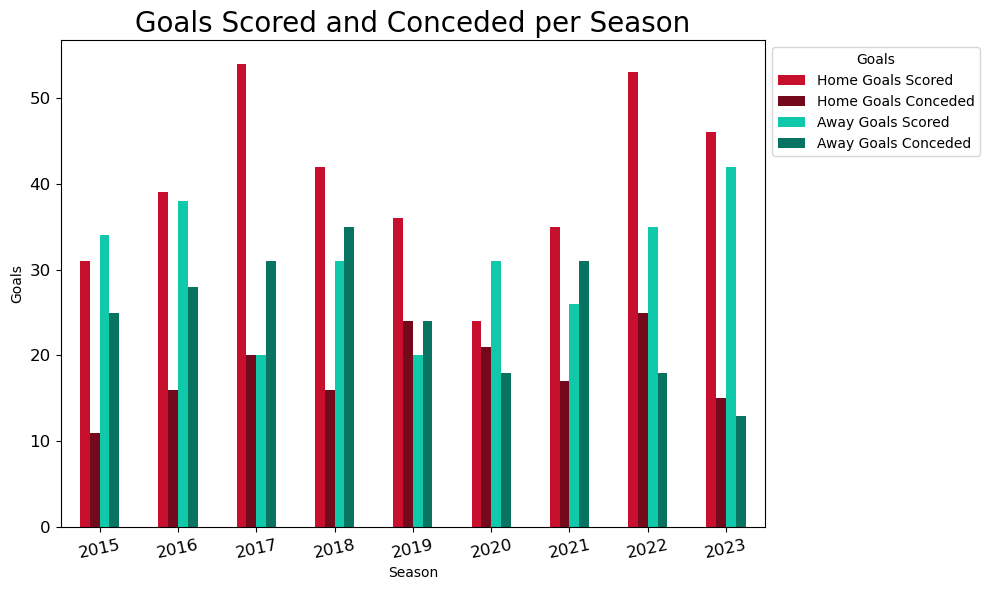

In [42]:
plot_team_goals(pl,'Arsenal',save_path='arsenal_goals.png')